<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S14-15/EVA4_S15A_data_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount and Fetch Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Prepare the dataset

Extract and combine all the data chunks to prepare the entire dataset.

In [2]:
import zipfile
import os

os.mkdir("/content/dataset")

files_to_extract = ["gen_fg_bg.zip", "fg_bg.zip", "fg_bg_depth_s00_e50.zip", "fg_bg_depth_s50_e75.zip", "fg_bg_depth_s75_e100.zip"]
for fp in files_to_extract:
  path_to_zip_file = f"/content/gdrive/My Drive/EVA4-Workspace/persons_fg/{fp}"
  directory_to_extract_to = '/content/dataset/'
  print("Extracting zip file: %s" % path_to_zip_file)
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
  print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/gen_fg_bg.zip
Extracted at: /content/dataset/
Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/fg_bg.zip
Extracted at: /content/dataset/
Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/fg_bg_depth_s00_e50.zip
Extracted at: /content/dataset/
Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/fg_bg_depth_s50_e75.zip
Extracted at: /content/dataset/
Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/fg_bg_depth_s75_e100.zip
Extracted at: /content/dataset/


In [0]:
!rm -rf /content/dataset/__MACOSX

## Data Statistics

Utils to display file structure, directory size and image dimensions

In [0]:
import os
import cv2
import subprocess

def list_files(startpath, cap_dir=3, cap_file=3):
    dcount = 0
    for root, dirs, files in os.walk(startpath):
        dcount += 1
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        count = 0
        for f in files:
            print('{}{}'.format(subindent, f))
            count += 1
            if count == cap_file:
                print('{}{}'.format(subindent, "..."))
                break
        if dcount == cap_dir:
             print("...")
             break

def du(path):
    return subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8')

def imsize(path):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return im.shape

Utils to compute mean and std of data

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

def compute_mean_std(path, bs=128, is_gray=False):
  transforms_list = []
  if is_gray:
    transforms_list.append(transforms.Grayscale())  
  transforms_list.append(transforms.ToTensor())

  dataset = torchvision.datasets.ImageFolder(root=path,
                                             transform=transforms.Compose(transforms_list))
  loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    num_workers=4,
    shuffle=False,
    pin_memory= True
  )

  mean = 0.0
  for data, _ in tqdm(loader, desc="Computing mean"):
    batch_samples = data.size(0)
    # Flatten each channel
    data = data.view(batch_samples, data.size(1), -1)
    # Since the denominator (224*224) is constant, instead of doing sum first and
    # then taking mean, we can directly take mean and sum it.
    mean += data.mean(2).sum(0)

  mean /= len(loader.dataset)

  std = 0.0
  for data, _ in tqdm(loader, desc="Computing std"):
    batch_samples = data.size(0)
    # Flatten each channel
    data = data.view(batch_samples, data.size(1), -1)
    # Sum (x-mean)^2 per channel across all batches pixels
    std += ((data - mean.unsqueeze(1))**2).sum([0,2])

  std = torch.sqrt(std / (len(loader.dataset)*224*224))
  print("\nMean: ", mean)
  print("Std: ", std)

Utils to display images in a grid

In [0]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob

def show_images(images, cols = 1, titles = None, figsize=(5,5)):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.axis("off")
        plt.imshow(image)
        plt.tight_layout()
        # a.set_title(title)
    # fig.set_size_inches(0.1*np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()
    plt.show()

def display_grid(base_path, n, ext=".jpg", sub_dirs=False, figsize=(5,5), off=0):
  input_files = []
  cols = int(np.sqrt(n))
  if sub_dirs:
    for bg_idx in range(off, n+off):
      path = f"{base_path}/bg_{bg_idx:02d}/*{ext}"
      input_files.append(glob.glob(path)[0])
  else:
    input_files = glob.glob(f"{base_path}/*{ext}")[:n]
  
  image_list = list(map(lambda im: imread(im), input_files))
  show_images(image_list, cols=cols, figsize=figsize)

### File Structure

In [22]:
path = "/content/dataset"
dirs = sorted(os.listdir(path))
print("File structure:")
print("dataset/")
for dir_name in dirs:
  print(f"{' ' * 4}{dir_name}/")
print("Sub-dirs count:", len(dirs))
print("Dir size:", du(path),"\n")

File structure:
dataset/
    bg/
    fg/
    fg_bg/
    fg_bg_depth/
    fg_bg_masks/
    fg_mask/
    labels/
Sub-dirs count: 7
Dir size: 7.3G 



### Background

File structure:
bg/
    bg_61.jpg
    bg_63.jpg
    bg_72.jpg
    ...
File count: 100
Image dimensions: (224, 224, 3)
Dir size: 2.5M 



Computing std: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]



Mean:  tensor([0.5039, 0.5001, 0.4849])
Std:  tensor([0.2465, 0.2463, 0.2582])



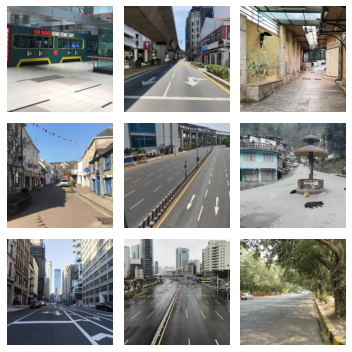

In [5]:
path = "/content/dataset/bg"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path),"\n")
!mkdir /content/bg_wrap
!cp -r /content/dataset/bg /content/bg_wrap/
compute_mean_std("/content/bg_wrap", bs=128, is_gray=False)
!rm -rf bg_wrap/
print()
display_grid(path, 9, ext=".jpg", sub_dirs=False, figsize=(5,5))

### Foreground

File structure:
fg/
    fg_21.png
    fg_29.png
    fg_77.png
    ...
File count: 100
Image dimensions: (105, 88, 4)
Dir size: 1.2M



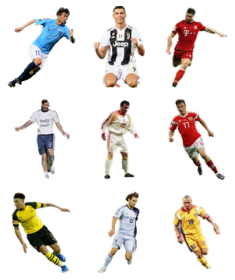

In [6]:
path = "/content/dataset/fg"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path))
print()
display_grid(path, 9, ext=".png", sub_dirs=False, figsize=(4,4))

### Foreground Mask

File structure:
fg_mask/
    fg_64.jpg
    fg_90.jpg
    fg_09.jpg
    ...
File count: 100
Image dimensions: (105, 63)
Dir size: 404K



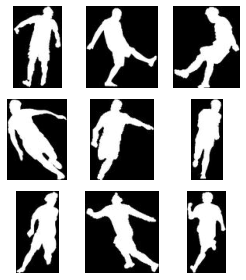

In [7]:
path = "/content/dataset/fg_mask"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path))
print()
display_grid(path, 9, ext=".jpg", sub_dirs=False, figsize=(4,4))

### Foreground Overlayed on Background

File structure:
fg_bg/
    bg_94/
        bg_94_fg_59_F_378383.jpg
        bg_94_fg_30_T_377226.jpg
        bg_94_fg_36_T_377442.jpg
        ...
    bg_08/
        bg_08_fg_83_T_035332.jpg
        bg_08_fg_63_T_034556.jpg
        bg_08_fg_55_F_034229.jpg
        ...
...
Sub-dirs count: 100
Files per sub-dir count: 4000
Image dimensions: (224, 224, 3)
Dir size: 4.2G 



Computing std: 100%|██████████| 391/391 [26:32<00:00,  4.07s/it]



Mean:  tensor([0.5056, 0.4969, 0.4817])
Std:  tensor([0.2486, 0.2490, 0.2604])



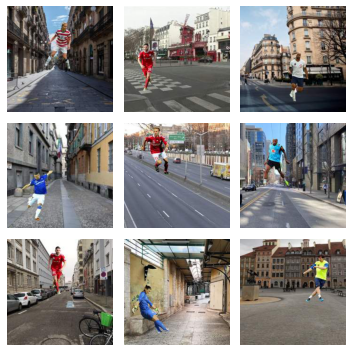

In [8]:
path = "/content/dataset/fg_bg"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=False)
print()
display_grid(path, 9, ext=".jpg", sub_dirs=True, figsize=(5,5), off=65)

### Foreground Overlayed on Background Mask

File structure:
fg_bg_masks/
    bg_94/
        bg_94_fg_59_F_378383.jpg
        bg_94_fg_30_T_377226.jpg
        bg_94_fg_36_T_377442.jpg
        ...
    bg_08/
        bg_08_fg_83_T_035332.jpg
        bg_08_fg_63_T_034556.jpg
        bg_08_fg_55_F_034229.jpg
        ...
...
Sub-dirs count: 100
Files per sub-dir count: 4000
Image dimensions: (224, 224)
Dir size: 1.6G 



Computing std: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s]



Mean:  tensor([0.0454])
Std:  tensor([0.2038])



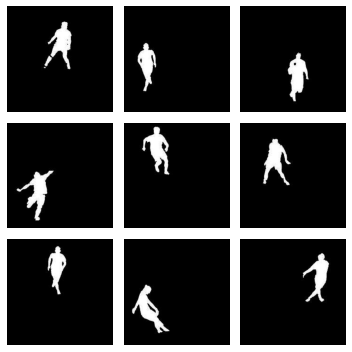

In [9]:
path = "/content/dataset/fg_bg_masks"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=True)
print()
display_grid(path, 9, ext=".jpg", sub_dirs=True, figsize=(5,5), off=65)

### Foreground Overlayed on Background Depth Map

File structure:
fg_bg_depth/
    bg_94/
        bg_94_fg_59_F_378383.jpg
        bg_94_fg_30_T_377226.jpg
        bg_94_fg_36_T_377442.jpg
        ...
    bg_08/
        bg_08_fg_83_T_035332.jpg
        bg_08_fg_63_T_034556.jpg
        bg_08_fg_55_F_034229.jpg
        ...
...
Sub-dirs count: 100
Files per sub-dir count: 4000
Image dimensions: (224, 224)
Dir size: 1.6G 



Computing std: 100%|██████████| 391/391 [04:56<00:00,  1.32it/s]



Mean:  tensor([0.4334])
Std:  tensor([0.2715])



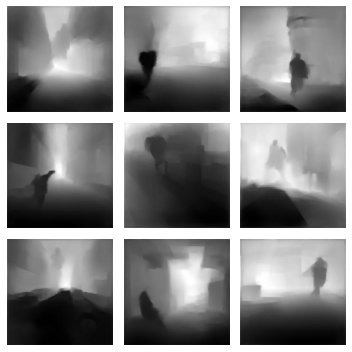

In [10]:
path = "/content/dataset/fg_bg_depth"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=True)
print()
display_grid(path, 9, ext=".jpg", sub_dirs=True, figsize=(5,5), off=65)

# Dataset Visualization

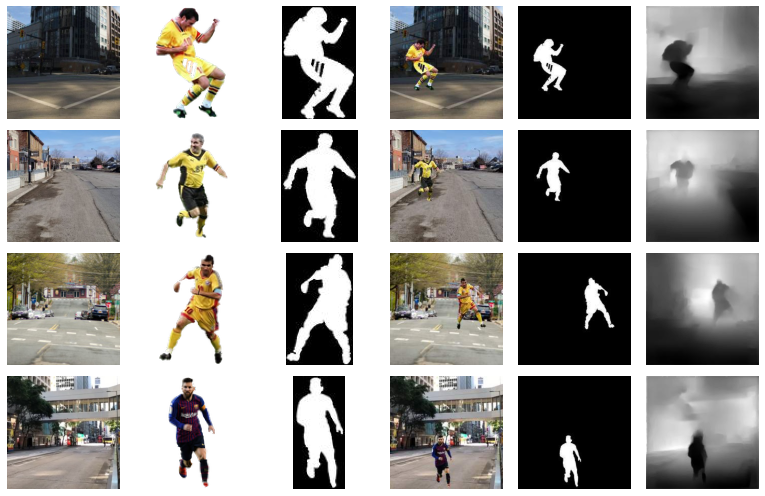

In [11]:
off = 85
base_path = "/content/dataset"
input_files = []
for bg_idx in range(off, 4+off):
  input_files.append(f"{base_path}/bg/bg_{bg_idx:02d}.jpg")
  input_files.append(f"{base_path}/fg/fg_{bg_idx:02d}.png")
  input_files.append(f"{base_path}/fg_mask/fg_{bg_idx:02d}.jpg")
  path = f"{base_path}/fg_bg/bg_{bg_idx:02d}/bg_{bg_idx:02d}_fg_{bg_idx:02d}*.jpg"
  path = glob.glob(path)[0]
  input_files.append(path)
  input_files.append(path.replace("/fg_bg/","/fg_bg_masks/"))
  input_files.append(path.replace("/fg_bg/","/fg_bg_depth/"))

image_list = list(map(lambda im: imread(im), input_files))
show_images(image_list, cols=4, figsize=(11,7))

# Dataset Saving

Compress Dataset and Store in Google Drive

In [12]:
import shutil
output_fname = "/content/dataset"
dir_name = "/content/dataset"
shutil.make_archive(output_fname, 'zip', dir_name)

'/content/dataset.zip'

In [0]:
!cp '/content/dataset.zip' '/content/gdrive/My Drive/EVA4-Workspace/persons_fg/'